# Maximum a posteriori signal detection

Digital signals are all around us. From the phone in our pockets to the massive infrastructure behind the Internet, they have enabled a wide variety of technologies, yet it is easy to take them for granted. We sometimes think of them as strings of zeros and ones traveling in a clear stream of data, but the truth is that as there are digital signals around us, we also have noise.

Let's assume a sender wants to transmit a message consisting of zeros and ones. For increased reliability, instead of transmitting them directly, the sender can send a specific sequence representing a zero, and a different sequence representing a one. We will call these sequences $\mathbf{S}_0$ and $\mathbf{S}_1$, here is an example:

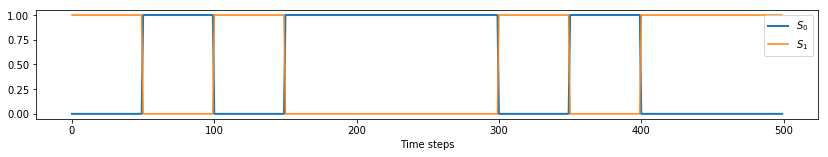

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

S0 = np.repeat([0, 1, 0, 1, 1, 1, 0, 1, 0, 0], 50)
S1 = -S0 + 1
messages = [S0, S1]
labels = ['$S_0$', '$S_1$']

plt.figure(figsize=(14, 2))
plt.plot(S0, label='$S_0$', linewidth=2)
plt.plot(S1, label='$S_1$')
plt.xlabel('Time steps')
plt.legend();

(You can see they seem to be complementary, for reasons I will explain in a moment). If the sender wants to represent a 0, it will send $\mathbf{S}_0$, otherwise it will send $\mathbf{S}_1$ to represent a 1. The outbound message goes through digital to analog converters, amplifiers, antennas, the air, drops of rain, buildings, cables and more, picking up noise, until it gets to the receiver. The noise is usually modeled as [Additive White Gaussian Noise](https://en.wikipedia.org/wiki/Additive_white_Gaussian_noise). Let's simulate it to get an idea of how bad it can be, using the $\mathbf{S}_0$ sequence:

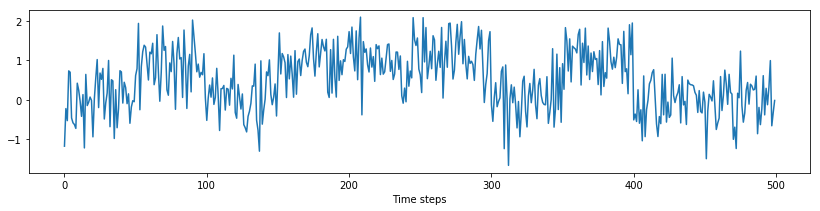

In [2]:
transmission0 = S0 + np.random.normal(scale=0.5, size=len(S0))
transmission1 = S1 + np.random.normal(scale=0.5, size=len(S1))
transmissions = [transmission0, transmission1]
plt.figure(figsize=(14, 3))
plt.plot(transmission0)
plt.xlabel('Time steps');

From my days as bachelor student in electronics, I can wistfully say: yes, this is how they would look on the oscilloscope. Luckily, we can still detect the original signal. We will examine a simple but powerful filter to detect digital signals: the **matched filter**. There are [different ways](https://en.wikipedia.org/wiki/Matched_filter#Derivation_of_the_matched_filter) to derive it and justify its optimality, here we will approach it from the point of view of probability theory.

Let $\mathbf{x} = \lbrace x_1, ... , x_n \rbrace$ be the received signal. Based on this observation, we would like to calculate the posterior probability of the sequences $\mathbf{S}_0$ and $\mathbf{S}_1$. Using the Maximum a Posteriori (MAP) principle, we will choose the sequence with the highest posterior probability as the sequence being sent.

For any sequence $\mathbf{S}_i$, this probability is given by Bayes' theorem as

$$
p(\mathbf{S}_i\mid\mathbf{x}) = \frac{p(\mathbf{S}_i)p(\mathbf{x}\mid\mathbf{S}_i)}{p(\mathbf{x})}
$$

Since the denominator does not change with the sequence, we can choose the sequence that maximizes the numerator. If we further assume that both sequences are equally likely, the problem reduces to finding the sequence that maximizes $p(\mathbf{x}\mid\mathbf{S}_i)$ (note that with this we went from MAP estimation to Maximum Likelihood Estimation).

Given an AWGN model for the noise, in which conditioned on the sequence all elements of the received signal are independent, we obtain

$$
\begin{align*}
p(\mathbf{x}\mid\mathbf{S}_i) &= \mathcal{N}(\mathbf{x}\mid \mathbf{S}_i, \sigma^2\mathbf{I}) \\
&\propto \exp\left\lbrace -\frac{1}{2\sigma^2}(\mathbf{x}-\mathbf{S}_i)^T(\mathbf{x}-\mathbf{S}_i)\right\rbrace
\end{align*} 
$$

Therefore, we need to maximize the term in the exponent with respect to $\mathbf{S}_i$, corresponding to

$$
\begin{align*}
-(\mathbf{x}-\mathbf{S}_i)^T(\mathbf{x}-\mathbf{S}_i) &= -\mathbf{x}^T\mathbf{x} + \mathbf{x}^T\mathbf{S}_i + \mathbf{S}_i \mathbf{x}^T - \mathbf{S}_i^T\mathbf{S}_i \\
&\approx \mathbf{x}^T\mathbf{S}_i - \mathbf{S}_i^T\mathbf{S}_i
\end{align*}
$$

Where we have kept only those terms depending on $\mathbf{S}_i$. We can design the sequences so that $\mathbf{S}_i^T\mathbf{S}_i$ is the same for all $i$. In fact, this is why I picked the signals to be complementary, so this is the case for our example:

In [3]:
print(np.all(np.dot(S0, S0) == np.dot(S1, S1)))

True


This last condition simplifies the expression being maximized and gives us the solution to the problem: the detected signal corresponds to the sequence that maximizes $\mathbf{x}^T\mathbf{S}_i$. Perhaps not coincidentally, this means that the message behind the noise is the one with the highest [correlation](https://en.wikipedia.org/wiki/Cross-correlation) with the received signal. Let's check!

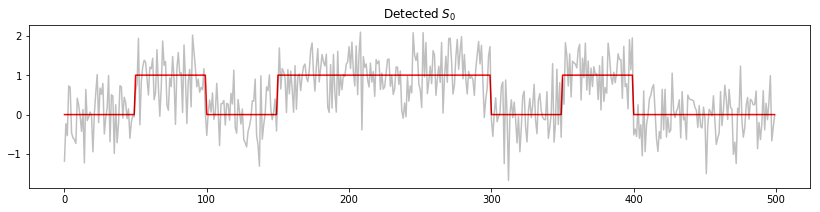

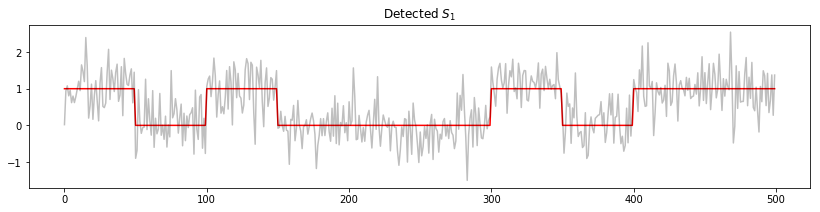

In [4]:
def detect_signal(noisy_signal):
    # Compute correlation with both templates
    correlations = [np.dot(S0, noisy_signal), np.dot(S1, noisy_signal)]
    # Choose template with highest correlation
    msg_idx = np.argmax(correlations)
    
    plt.figure(figsize=(14, 3))
    plt.plot(messages[msg_idx], 'r')
    plt.plot(transmissions[msg_idx], 'k', alpha=0.25)
    plt.title('Detected {:s}'.format(labels[msg_idx]))
        
    
detect_signal(transmission0)
detect_signal(transmission1)

It works! This is just a small example, however, and there are other mechanisms needed for this method to work well in the contexts of digital communications, such as modulation and synchronization. On the other hand, as a direct application of Bayes' theorem, it serves its purpose really well.